In [1]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
from sklearn.metrics import confusion_matrix

In [2]:
ohco = ['speech_id','speaker','para_id','sent_id','token_id']

In [3]:
df = pd.read_json('data/ucsb_speeches_2016.json')

In [4]:
df.head()

,link,title,date,person,transcript
0,/documents/remarks-town-hall-meeting-portsmout...,"Remarks at a Town Hall Meeting in Portsmouth, ...",2015-12-29 00:00:00+00:00,Hillary Clinton,\nCLINTON: Wow. Thank you. Thank you all. Than...
1,/documents/remarks-the-university-minnesota-mi...,Remarks at the University of Minnesota in Minn...,2015-12-15 00:00:00+00:00,Hillary Clinton,\nThank you. Thank you all very much. Thank yo...
2,/documents/interview-with-george-stephanopoulo...,Interview with George Stephanopoulos of ABC Ne...,2015-12-06 00:00:00+00:00,Hillary Clinton,\nSTEPHANOPOULOS: And we'll hear more on that ...
3,/documents/interview-with-charlie-rose,Interview with Charlie Rose,2015-12-01 00:00:00+00:00,Hillary Clinton,"\nROSE: She is a former first lady, a former s..."
4,/documents/remarks-and-question-and-answer-ses...,Remarks and a Question and Answer Session at t...,2015-11-19 00:00:00+00:00,Hillary Clinton,\nCLINTON: Thank you. Thank you very much. [ap...


In [5]:
df.index.name = 'speech_id'
library = df[['link','title','date','person']]

In [6]:
# first OHCO level - split out speakers, using e.g. "CLINTON:"
# set default speaker for each speech - we'll set the specific ones later.
df['speaker'] = [x[1] for x in df['person'].str.upper().str.rsplit(' ',1)]

In [7]:
df = df.reset_index().set_index(['speech_id','speaker'])

In [8]:
# second OHCO level - split out paragraphs, using "\n" as the separator (for these transcripts). 
# Remove initial/trailing whitespace, including \n
df = df['transcript'].str.strip().str.split("\n", expand=True)\
    .stack().to_frame().rename(columns={0:'para_str'})
df.index.names = ohco[0:3]

In [9]:
df = df.reset_index().set_index(['speech_id','para_id'])

In [10]:
# whenever a paragraph starts with a caps name e.g. CLINTON:
# use that as the speaker until the next caps name
df['speaker'] = df['para_str'].str.extract(r'([A-Z]+)(:)')[0].ffill()
# remove the non-Trump/Clinton speakers
df = df[df['speaker'].isin(['TRUMP','CLINTON'])]

In [11]:
df = df.reset_index().set_index(ohco[0:3])

In [12]:
# remove the caps names
df['para_str'] = df['para_str'].str.replace(r'[A-Z]+: ','')
# add spaces around dashes - count them as 2 words
df['para_str'] = df['para_str'].str.replace('—', ' — ')\
    .str.replace('-', ' - ')

In [13]:
# third ohco level - sentence

# Alvarado used NLTK sentence tokenizer to split sentences. 
# but let's try it the lazy way to start
#df = df['para_str'].str.split("[.!?]+", expand=True)\
#    .stack().to_frame().rename(columns={0:'sent_str'})

# alternate method - sentence tokenizer
df = df['para_str'].apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
    .stack()\
    .to_frame()\
    .rename(columns={0:'sent_str'})


df.index.names = ohco[0:4]

In [14]:
# drop 0-length strings (usually at end of paragraph)
df = df[df['sent_str'].str.len() > 0]

In [15]:
df.head()

sent_str
speech_id speaker para_id sent_id                                                   
0         CLINTON 0       0                                                     Wow.
                          1                                               Thank you.
                          2                                           Thank you all.
                          3                                               Thank you.
                          4        I am really delighted to be here on the first ...

In [16]:
# fourth ohco level - tokens

In [17]:
token = df['sent_str'].apply(lambda x: pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x))))\
    .stack().to_frame()\
    .rename(columns={0:'pos_tuple'})
token['pos'] = token.pos_tuple.apply(lambda x: x[1])
token['token_str'] = token.pos_tuple.apply(lambda x: x[0])
token = token.drop('pos_tuple', 1)

In [18]:
token.index.names = ohco # ok, all done

In [19]:
token.head()

pos token_str
speech_id speaker para_id sent_id token_id               
0         CLINTON 0       0       0          NN      Wow.
                          1       0         NNP     Thank
                                  1          NN      you.
                          2       0         NNP     Thank
                                  1         PRP       you

In [20]:
# Lowercase, remove non-word characters
token['term_str'] = token['token_str'].str.lower().str.replace('[\W_]', '')
# drop words which consist entirely of non-word characters
token = token[token.term_str!=''].sort_index()

In [21]:
# testing - using stems instead of base term str
# worse performance - 25% accuracy
#token['term_str_orig'] = token['term_str']
# simple stemming - add to token so it's available in everything later
#from nltk.stem.porter import PorterStemmer

#stemmer = PorterStemmer()
#token['term_str'] = token.term_str.apply(stemmer.stem)

In [22]:
# testing - use bigrams instead of base term str
# even worse performance! 10% accuracy
#token['term_str_orig'] = token['term_str']

# n+1
#token['next_term_str'] = token.groupby(ohco[:4])['term_str'].shift(-1)

#token['term_str'] = (token['term_str'] + ' ' + token['next_term_str'])
#token = token.dropna()

In [23]:
# Checkpoint
token.to_parquet('data/token.parquet')
library.to_parquet('data/library.parquet')

In [24]:
# Load from checkpoint
if 'token' not in locals():
    token = pd.read_parquet('data/token.parquet')
if 'library' not in locals():
    library = pd.read_parquet('data/library.parquet')

In [25]:
# create vocab table
# 
vocab = token.term_str.value_counts().to_frame().rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
vocab.index.name = 'term_id'

In [26]:
# add stopwords
vocab['stop'] = 0
vocab.loc[vocab['term_str'].isin(nltk.corpus.stopwords.words('english')),'stop'] = 1

In [27]:
# add term rank 
if 'term_rank' not in vocab.columns:
    vocab = vocab.sort_values('n', ascending=False).reset_index()
    vocab.index.name = 'term_rank'
    vocab = vocab.reset_index().set_index('term_id')
    vocab['term_rank'] = vocab['term_rank'] + 1 # start with 1 instead of 0

In [28]:
vocab.sort_values('n', ascending=False).head()

,term_rank,term_str,n,stop
term_id,,,,
10012,1,the,13625,1
10126,2,to,12744,1
729,3,and,12268,1
5103,4,i,7464,1
6923,5,of,6933,1


In [29]:
# add term id back to token table, for easy joining
token['term_id'] = token.term_str.map(vocab.reset_index().set_index('term_str').term_id)

In [30]:
# Checkpoint
vocab.to_parquet('data/vocab.parquet')

## Create DT matrices 
(Document-Term matrix, using Bag of Words and TF-IDF)

One each for Trump and Clinton

In [31]:
# Load from checkpoint
if 'vocab' not in locals():
    vocab = pd.read_parquet('data/vocab.parquet')

In [32]:
bag = ohco[:1] # bag size = 1 speech

In [33]:
# identify stopwords
token['stop'] = 0
token.loc[token['term_str'].isin(nltk.corpus.stopwords.words('english')),'stop'] = 1

In [34]:
#remove stopwords
token=token[token.stop==0]

In [35]:
# 100 speeches, take 20% for test set
test_ids = np.random.choice(token.reset_index().speech_id.unique(),size=20,replace=False)

In [36]:
token = token.reset_index().set_index('speech_id')

In [37]:
test_token = token.loc[test_ids]
train_token = token.loc[~token.index.isin(test_ids)]

In [38]:
token

,speaker,para_id,sent_id,token_id,pos,token_str,term_str,term_id,stop
speech_id,,,,,,,,,
0,CLINTON,0,0,0,NN,Wow.,wow,11049,0
0,CLINTON,0,1,0,NNP,Thank,thank,10001,0
0,CLINTON,0,2,0,NNP,Thank,thank,10001,0
0,CLINTON,0,3,0,NNP,Thank,thank,10001,0
0,CLINTON,0,4,2,RB,really,really,8151,0
...,...,...,...,...,...,...,...,...,...
162,CLINTON,273,0,0,NNP,Thank,thank,10001,0
162,CLINTON,273,0,3,VBP,"much,",much,6637,0
162,CLINTON,273,0,4,NNP,Chris.,chris,1965,0


In [39]:
# Split into Trump/Clinton
clinton_train = train_token.query('speaker=="CLINTON"')
trump_train = train_token.query('speaker=="TRUMP"')

In [40]:
clinton_count = len(clinton_train.index.unique())
trump_count = len(trump_train.index.unique())
total_count = clinton_count + trump_count
priors = [clinton_count/total_count,trump_count/total_count]
priors

[0.4878048780487805, 0.5121951219512195]

In [41]:
def create_vocab(token, token_full, a=1):
    # a=1 for Laplace smoothing
    vocab = token.term_str.value_counts().to_frame().rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
    vocab.index.name = 'term_id'

    vocab_full = token_full.term_str.value_counts().to_frame().rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
    vocab_full.index.name = 'term_id'

    #Add all terms with a 0 for any terms not in training set
    to_add=vocab_full[~vocab_full['term_str'].isin(vocab['term_str'])]
    to_add['n']=0
    vocab=vocab.append(to_add)

    if 'term_rank' not in vocab.columns:
        vocab = vocab.sort_values('n', ascending=False).reset_index()
        vocab.index.name = 'term_rank'
        vocab = vocab.reset_index().set_index('term_id')
        vocab['term_rank'] = vocab['term_rank'] + 1 # start with 1 instead of 0
    token['term_id'] = token.term_str.map(vocab.reset_index().set_index('term_str').term_id)
    BOW = token.groupby(bag+['term_id']).term_id.count()\
    .to_frame().rename(columns={'term_id':'n'})
    DTCM = BOW['n'].unstack().fillna(0).astype('int')
    # Term frequency - normalized
    TF = DTCM #(DTCM.T / DTCM.T.sum()).T 
    DF = DTCM[DTCM > 0].count()
    freq=TF.sum().reset_index()
    #freq=DTCM.sum().reset_index() #optional to get more variance in the likelihood
    vocab['freq'] = freq[0]
    tf = vocab.freq # term frequency 
    N = vocab.freq.sum() # sum of all term frequencies in this class
    V = vocab[vocab.freq > 0].shape[0] # vocab size
    # https://stackoverflow.com/questions/3704570/in-python-small-floats-tending-to-zero
    # https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html
    # using the log likelihood for these reasons
    vocab['likelihood'] = np.log((tf+a) / (N + a*V))
    vocab.sort_values('likelihood',ascending=False)
    return vocab

In [42]:
vocab_c = create_vocab(clinton_train, train_token).reset_index().set_index('term_str')
vocab_t = create_vocab(trump_train, train_token).reset_index().set_index('term_str')

<ipython-input-41-3e68dfb70ced>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_add['n']=0
<ipython-input-41-3e68dfb70ced>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token['term_id'] = token.term_str.map(vocab.reset_index().set_index('term_str').term_id)


In [58]:
vocab_c = vocab_c.fillna({'likelihood':0})
vocab_t = vocab_t.fillna({'likelihood':0})
vocab_c

,term_id,term_rank,n,freq,likelihood
term_str,,,,,
know,3604,1,1018,1018.0,-4.408656
people,4574,2,720,720.0,-4.754594
going,2836,3,632,632.0,-4.884763
think,6304,4,588,588.0,-4.956807
get,2806,5,491,491.0,-5.136754
...,...,...,...,...,...
eh,3186,10051,0,3.0,-9.948939
eisenhower,3191,10052,0,1.0,-10.642086
eke,3193,10053,0,58.0,-7.257696


In [59]:
def NB_classifier(token_test, class1_vocab, class2_vocab, class_1_name = 'Class 1', class_2_name = 'Class 2', priors=[.5,.5]):
    d = {'speech_id': token_test.index.unique(), 'true_value': "", 'prediction': ""}
    results = pd.DataFrame(d).set_index('speech_id')
    
    for i in results.index:
        results['true_value'].loc[i] = test_token.at[i,'speaker'][0]
        
        speech = token_test.loc[i]
        
        speech = speech.merge(class1_vocab['likelihood'], how='left', on="term_str")\
        .rename(columns={'likelihood': class_1_name})
        speech = speech.merge(class2_vocab['likelihood'], how='left', on="term_str")\
        .rename(columns={'likelihood': class_2_name})
        
        predict = pd.DataFrame(speech[[class_1_name,class_2_name]].sum())
        logpriors = np.log(priors)
        predict[0] = predict[0] + logpriors
        predict = predict.sort_values(by=0, ascending=False)
        classification = predict.index[0]
        
        results['prediction'].loc[i] = classification
        
    return results

In [60]:
# class 1 is clinton, class 2 is trump

results=NB_classifier(test_token,vocab_c,vocab_t, class_1_name = 'CLINTON', class_2_name = 'TRUMP', priors=priors)
results

,true_value,prediction
speech_id,,
60,CLINTON,TRUMP
29,CLINTON,CLINTON
130,TRUMP,CLINTON
12,CLINTON,CLINTON
156,CLINTON,CLINTON
114,TRUMP,TRUMP
131,TRUMP,TRUMP
0,CLINTON,CLINTON
138,TRUMP,CLINTON


In [61]:
confusion_matrix(results.true_value, results.prediction)

array([[8, 1],
       [4, 7]])

In [62]:
speech = test_token.loc[test_token.head(1).index[0]]
        
speech = speech.merge(vocab_c['likelihood'], how='left', on="term_str")\
        .rename(columns={'likelihood': 'clinton'})
speech = speech.merge(vocab_t['likelihood'], how='left', on="term_str")\
        .rename(columns={'likelihood': 'trump'})
        
predict = pd.DataFrame(speech[['clinton','trump']].sum())
logpriors = np.log(priors)
predict[0] = predict[0] + logpriors
predict = predict.sort_values(by=0, ascending=False)

In [63]:
predict

,0
trump,-6972.346557
clinton,-7380.324898


In [64]:
vocab_t.loc['fallen']

term_id       2661.000000
term_rank     3147.000000
n                3.000000
freq             3.000000
likelihood     -10.196857
Name: fallen, dtype: float64

In [65]:
speech

,speaker,para_id,sent_id,token_id,pos,token_str,term_str,term_id,stop,clinton,trump
0,CLINTON,0,0,0,NNP,Thank,thank,10001,0,-6.498951,-5.882707
1,CLINTON,1,0,1,CD,18,18,69,0,-8.850327,-8.944094
2,CLINTON,1,0,2,NN,"days,",days,2739,0,-7.869497,-7.018803
3,CLINTON,1,0,5,VBG,going,going,4554,0,-4.884763,-4.602145
4,CLINTON,1,0,7,VB,win,win,10967,0,-7.697647,-6.495555
...,...,...,...,...,...,...,...,...,...,...,...
944,CLINTON,88,0,3,NNP,America,america,700,0,-6.556110,-5.589189
945,CLINTON,88,0,4,NNP,Safe,safe,8753,0,-7.621661,-7.164310
946,CLINTON,89,0,3,NNP,Make,make,6204,0,-5.605133,-5.708220
947,CLINTON,89,0,4,NNP,America,america,700,0,-6.556110,-5.589189


In [66]:
speech[speech['clinton'].isnull().values]

,speaker,para_id,sent_id,token_id,pos,token_str,term_str,term_id,stop,clinton,trump
114,CLINTON,7,1,24,NN,orbit,orbit,7031,0,NaN,NaN
257,CLINTON,16,0,30,VB,resign.,resign,8472,0,NaN,NaN
267,CLINTON,17,0,18,JJ,inappropriate.,inappropriate,5213,0,NaN,NaN
272,CLINTON,18,0,8,NNP,"$64,000",64000,293,0,NaN,NaN
274,CLINTON,18,0,12,NN,contestant,contestant,2388,0,NaN,NaN
368,CLINTON,30,0,7,VBN,summed,summed,9718,0,NaN,NaN
383,CLINTON,32,0,0,CD,47,47,239,0,NaN,NaN
479,CLINTON,39,0,21,VB,undertake,undertake,10442,0,NaN,NaN
488,CLINTON,40,0,5,VBN,mismanaged,mismanaged,6514,0,NaN,NaN
491,CLINTON,40,0,10,NNS,bureaucracies,bureaucracies,1619,0,NaN,NaN


## Plotting

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
token = token.reset_index()
token = token.merge(vocab_c['likelihood'], how='left', on="term_str")\
        .rename(columns={'likelihood': 'p_clinton'})
token = token.merge(vocab_t['likelihood'], how='left', on="term_str")\
        .rename(columns={'likelihood': 'p_trump'})
token = token.set_index('speech_id')

In [72]:
tg = token.reset_index().groupby(['speech_id','speaker'])\
    .agg({'p_clinton':'sum','p_trump':'sum','token_id':'count'}).reset_index()
tg = tg.rename(columns={'token_id': 'length'})

SpecificationError: nested renamer is not supported

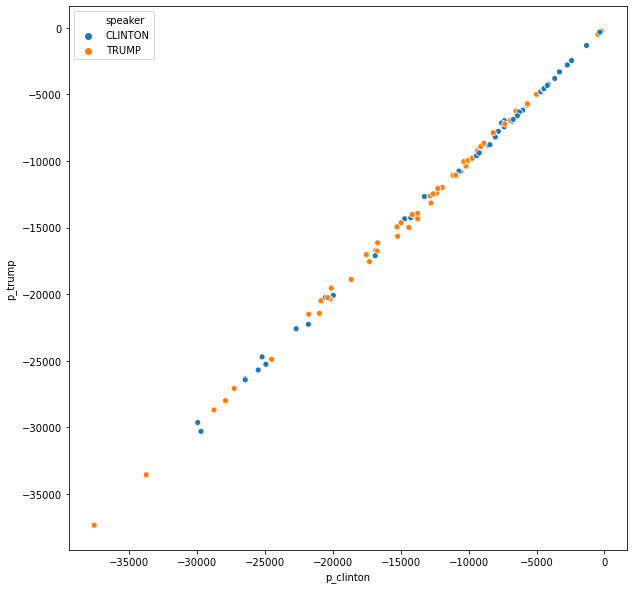

In [70]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='p_clinton',y='p_trump',hue='speaker', data=tg)

In [71]:
import plotly.express as px
fig = px.scatter(tg, x='p_clinton',y='p_trump',color='speaker', size="length", hover_data=['speech_id'])
fig.show()

In [57]:
tg

,speech_id,speaker,p_clinton,p_trump,length
0,0,CLINTON,-21812.397483,-22267.815029,3034
1,1,CLINTON,-20560.319934,-20251.980141,2521
2,2,CLINTON,-10614.424497,-10791.320107,1401
3,2,TRUMP,-219.448387,-236.166641,29
4,3,CLINTON,-26468.868005,-26357.532605,3465
...,...,...,...,...,...
97,158,CLINTON,-6723.515124,-6880.788843,863
98,159,CLINTON,-4447.737716,-4552.056564,570
99,160,CLINTON,-9424.927525,-9610.621579,1247
100,161,CLINTON,-4211.454906,-4332.272106,579


In [73]:
token

,speaker,para_id,sent_id,token_id,pos,token_str,term_str,term_id,stop,p_clinton,p_trump,p_clinton,p_trump
speech_id,,,,,,,,,,,,,
0,CLINTON,0,0,0,NN,Wow.,wow,11049,0,-9.255792,-8.638712,-9.255792,-8.638712
0,CLINTON,0,1,0,NNP,Thank,thank,10001,0,-6.498951,-5.882707,-6.498951,-5.882707
0,CLINTON,0,2,0,NNP,Thank,thank,10001,0,-6.498951,-5.882707,-6.498951,-5.882707
0,CLINTON,0,3,0,NNP,Thank,thank,10001,0,-6.498951,-5.882707,-6.498951,-5.882707
0,CLINTON,0,4,2,RB,really,really,8151,0,-5.563792,-6.265031,-5.563792,-6.265031
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,CLINTON,273,0,0,NNP,Thank,thank,10001,0,-6.498951,-5.882707,-6.498951,-5.882707
162,CLINTON,273,0,3,VBP,"much,",much,6637,0,-6.338021,-6.207873,-6.338021,-6.207873
162,CLINTON,273,0,4,NNP,Chris.,chris,1965,0,-7.869497,-10.196857,-7.869497,-10.196857


In [74]:
a = 1
token1 = clinton_train
token_full = train_token
# a=1 for Laplace smoothing
vocab1 = token1.term_str.value_counts().to_frame().rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
vocab1.index.name = 'term_id'

vocab_full = token_full.term_str.value_counts().to_frame().rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
vocab_full.index.name = 'term_id'

#Add all terms with a 0 for any terms not in training set
to_add=vocab_full[~vocab_full['term_str'].isin(vocab1['term_str'])]
to_add['n']=0
vocab1=vocab1.append(to_add)

token1['term_id'] = token1.term_str.map(vocab.reset_index().set_index('term_str').term_id)
BOW = token1.groupby(bag+['term_id']).term_id.count()\
    .to_frame().rename(columns={'term_id':'n'})
DTCM = BOW['n'].unstack().fillna(0).astype('int')
# Term frequency - normalized
TF = DTCM #(DTCM.T / DTCM.T.sum()).T 
DF = DTCM[DTCM > 0].count()
freq=TF.sum().reset_index()
#freq=DTCM.sum().reset_index() #optional to get more variance in the likelihood
vocab1['freq'] = freq[0]
tf = vocab1.freq # term frequency 
N = vocab1.freq.sum() # sum of all term frequencies in this class
V = vocab1[vocab1.freq > 0].shape[0] # vocab size
# https://stackoverflow.com/questions/3704570/in-python-small-floats-tending-to-zero
# https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html
# using the log likelihood for these reasons
vocab1['likelihood'] = np.log((tf+a) / (N + a*V))
vocab1.sort_values('likelihood',ascending=False)



<ipython-input-74-5bf9a51ae2b1>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-74-5bf9a51ae2b1>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,term_str,n,freq,likelihood
term_id,,,,
3604,extorted,0,1018.0,-4.408656
3604,know,1018,1018.0,-4.408656
4574,people,720,720.0,-4.754594
2836,going,632,632.0,-4.884763
6304,think,588,588.0,-4.956807
...,...,...,...,...
10026,yen,0,NaN,NaN
10032,yitzhak,0,NaN,NaN
10034,yoga,0,NaN,NaN
